In [161]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import pickle

The objective is to predict the revenue of shops. Each row of our data contains the following information:

* shop_ID : Shop's unique identifier.
* day_of_the_week : Encoded from 0 to 6.
* date : day, month and year of the data point.
* number of customers : Quantity of customers that showed up that day.
* open : Binary variable equal to 0 if shop closed that day and 1 if shop open.
* promotion : Binary variable equal to 0 if shop had no promotions that day and 1 if it did.
* state_holiday : Encoded 0, a, b, c indicating if there was a state holiday at all (0 if not), and otherwise, the number indicates which state holiday it was.
* school_holiday : Binary variable equal to 0 if there was a school holiday that day and 1 if not.

In [162]:
sales = pd.read_csv('sales.csv')

In [163]:
sales.shape

(640840, 10)

In [164]:
sales.head()

,Unnamed: 0,store_ID,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales
0,425390,366,4,2013-04-18,517,1,0,0,0,4422
1,291687,394,6,2015-04-11,694,1,0,0,0,8297
2,411278,807,4,2013-08-29,970,1,1,0,0,9729
3,664714,802,2,2013-05-28,473,1,1,0,0,6513
4,540835,726,4,2013-10-10,1068,1,1,0,0,10882


## we have 10 columns, but the last one `sales` is our target. So we have to divide the dataset into features and labels. The first column `Unnamed: 0` is like the ID for each row.

In [165]:
sales.dtypes

Unnamed: 0              int64
store_ID                int64
day_of_week             int64
date                   object
nb_customers_on_day     int64
open                    int64
promotion               int64
state_holiday          object
school_holiday          int64
sales                   int64
dtype: object

In [166]:
features = sales.drop(columns=['sales']).copy()
labels = sales[['sales']]

In [167]:
features.dtypes

Unnamed: 0              int64
store_ID                int64
day_of_week             int64
date                   object
nb_customers_on_day     int64
open                    int64
promotion               int64
state_holiday          object
school_holiday          int64
dtype: object

In [168]:
labels.dtypes

sales    int64
dtype: object

## For sales it makes more sense to have values like float

In [169]:
labels = labels.astype('float')
labels.dtypes

sales    float64
dtype: object

## `date` columns should be split into Year - Month - Day

In [170]:
date = ['Year','Month','Day']
for days in date:
    dd = features['date'].apply(lambda x: list(x.split('-')))
    index = date.index(str(days))
    features[str(days)] = dd.apply(lambda x: x[index])
    features[str(days)] = features[str(days)].astype('int')
features.drop(columns=['date'],inplace=True)
features.head()

,Unnamed: 0,store_ID,day_of_week,nb_customers_on_day,open,promotion,state_holiday,school_holiday,Year,Month,Day
0,425390,366,4,517,1,0,0,0,2013,4,18
1,291687,394,6,694,1,0,0,0,2015,4,11
2,411278,807,4,970,1,1,0,0,2013,8,29
3,664714,802,2,473,1,1,0,0,2013,5,28
4,540835,726,4,1068,1,1,0,0,2013,10,10


### Now let's look `state_holiday` column

`state_holiday`: Encoded 0, a, b, c indicating if there was a state holiday at all (0 if not), and otherwise, the number indicates which state holiday it was

Let's transform this into a binnary type. we just want to know if was holiday or not.

In [144]:
features['state_holiday'].unique()

array(['0', 'a', 'c', 'b'], dtype=object)

In [171]:
features['state_holiday'] = features['state_holiday'].apply(lambda x: 0 if x==0 else 1)

## Checking the types of columns

In [146]:
features.dtypes

Unnamed: 0              int64
store_ID                int64
day_of_week             int64
nb_customers_on_day     int64
open                    int64
promotion               int64
state_holiday           int64
school_holiday          int64
Year                   object
Month                  object
Day                    object
dtype: object

## Missing values

In [147]:
features.isnull().sum()

Unnamed: 0             0
store_ID               0
day_of_week            0
nb_customers_on_day    0
open                   0
promotion              0
state_holiday          0
school_holiday         0
Year                   0
Month                  0
Day                    0
dtype: int64

In [148]:
features.isna().sum()

Unnamed: 0             0
store_ID               0
day_of_week            0
nb_customers_on_day    0
open                   0
promotion              0
state_holiday          0
school_holiday         0
Year                   0
Month                  0
Day                    0
dtype: int64

### we don't have any missing values, so we can continue

## Let's check if the columns in this dataset are strongly correlated.

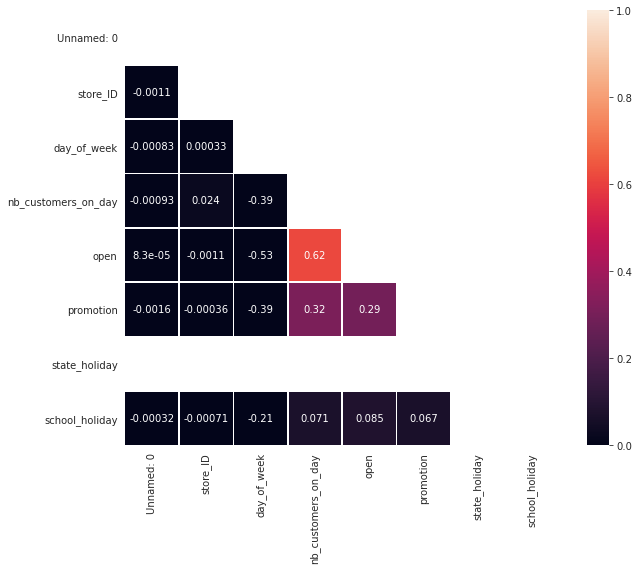

In [149]:
corr = features.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10,8))
    ax = sns.heatmap(corr, mask=mask,vmin=0, vmax=1,annot=True,linewidths=.5, square=True)

## We don't have any strong correlation between our features, so we can move on

## Look for the first 2 columns

The `Unnamed: 0` we can drop and let's go deep into `store_ID`

In [172]:
features.drop(columns=['Unnamed: 0'],inplace=True)

In [151]:
features['store_ID'].sort_values(ascending=True).unique()

array([   1,    2,    3, ..., 1113, 1114, 1115], dtype=int64)

In [152]:
len(features['store_ID'].unique())

1115

### we have 1115 different codes for stores, that means we collected information from 1115 stores. We have to create a dummies for this collumn but first bin the stores as Higher Sales, Medium Sales and Low Sales

In [173]:
display(features.head())
display(labels.head())

,store_ID,day_of_week,nb_customers_on_day,open,promotion,state_holiday,school_holiday,Year,Month,Day
0,366,4,517,1,0,1,0,2013,4,18
1,394,6,694,1,0,1,0,2015,4,11
2,807,4,970,1,1,1,0,2013,8,29
3,802,2,473,1,1,1,0,2013,5,28
4,726,4,1068,1,1,1,0,2013,10,10


,sales
0,4422.0
1,8297.0
2,9729.0
3,6513.0
4,10882.0


In [174]:
features.dtypes

store_ID               int64
day_of_week            int64
nb_customers_on_day    int64
open                   int64
promotion              int64
state_holiday          int64
school_holiday         int64
Year                   int32
Month                  int32
Day                    int32
dtype: object

## KNN model

### This model doesn't accept date columns

In [119]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features_wo_date,labels, test_size=0.25, random_state=1)

In [120]:
from sklearn.neighbors import KNeighborsRegressor

# create knn model
knnr = KNeighborsRegressor(n_neighbors = 5)

# Train the knn model
model = knnr.fit(X_train, y_train)

# Predict and score the model
y_pred = knnr.predict(X_test)
knnr.score(X_test, y_test)

0.9047056124505877

In [121]:
# cross validation

from sklearn.model_selection import cross_validate

print(cross_validate(model,X_train, y_train, cv=4)) # checking for overfitting

{'fit_time': array([3.1904726 , 3.08275962, 3.07481384, 3.12863183]), 'score_time': array([1.61072159, 1.45408177, 1.41717458, 1.71843982]), 'test_score': array([0.89790412, 0.89705911, 0.89701559, 0.8971517 ])}


In [32]:
from sklearn import metrics
from sklearn.metrics import r2_score

print("test data accuracy was ",model.score(X_test,y_test))
print("train data accuracy was ", model.score(X_train, y_train))
print('R-squared',r2_score(y_test, y_pred))

test data accuracy was  0.9047056124505877
train data accuracy was  0.9394977702524527
R-squared 0.9047056124505877


## Decision tree regression

In [175]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features,labels, test_size=0.25, random_state=1)

In [176]:
from sklearn.tree import DecisionTreeRegressor
regr = DecisionTreeRegressor()

model = regr.fit(X_train, y_train)
regr.score(X_test, y_test)

0.8985528114336293

In [177]:
# Predict and score the model
y_pred = model.predict(X_test)
model.score(X_test, y_test)

0.8985528114336293

In [178]:
# cross validation

from sklearn.model_selection import cross_validate

print(cross_validate(model,X_train, y_train, cv=5)) # checking for overfitting

{'fit_time': array([2.68880725, 2.47238755, 2.50731826, 2.45643091, 2.53219104]), 'score_time': array([0.06685734, 0.0628376 , 0.06384134, 0.06283998, 0.06086922]), 'test_score': array([0.88629781, 0.88936031, 0.88941231, 0.8866051 , 0.88486577])}


In [179]:
from sklearn import metrics
from sklearn.metrics import r2_score

print("test data accuracy was ",model.score(X_test,y_test))
print("train data accuracy was ", model.score(X_train, y_train))
print('R-squared',r2_score(y_test, y_pred))

test data accuracy was  0.8985528114336293
train data accuracy was  1.0
R-squared 0.8985528114336293


In [180]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
xgb_reg.score(X_test,y_test)

0.9619810378315167

In [181]:
# Predict and score the model
y_pred = xgb_reg.predict(X_test)
xgb_reg.score(X_test, y_test)

0.9619810378315167

In [182]:
# cross validation

from sklearn.model_selection import cross_validate

print(cross_validate(xgb_reg,X_train, y_train, cv=5)) # checking for overfitting

{'fit_time': array([ 9.20837092,  9.33749247,  9.29912853,  9.28815794, 11.13438225]), 'score_time': array([0.13763309, 0.16755414, 0.15558457, 0.13165021, 0.16554594]), 'test_score': array([0.96152377, 0.96112798, 0.96114808, 0.96111433, 0.96281324])}


In [130]:
from sklearn import metrics
from sklearn.metrics import r2_score

print("test data accuracy was ",xgb_reg.score(X_test,y_test))
print("train data accuracy was ", xgb_reg.score(X_train, y_train))
print('R-squared',r2_score(y_test, y_pred))

test data accuracy was  0.9582977700458698
train data accuracy was  0.9594572806038043
R-squared 0.9582977700458698


In [183]:
final_model = xgb_reg
pickle.dump(final_model, open('model.pkl','wb'))
X_test.to_pickle('xtest.p')
y_test.to_pickle('ytest.p')